## Proof of concept, training on CityScapes
Adopted from SMP [Segmentation Models Pytorch](https://github.com/qubvel/segmentation_models.pytorch)

Specifically, modified this notebook: [Segmentation on CamVid](https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb)

both notebook 3a and 3b are there only to ensure that the dataset+SMP combination works properly

In [8]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import sys
sys.path.append("..")

import numpy as np
import utils.utils as CU
import utils.dataloaders as CD

import albumentations as albu
from albumentations.augmentations.geometric.resize import Resize

In [9]:
DATA_DIR = '/mnt/ml-data-storage/jens/CityScapes/images'
LABEL_DIR = DATA_DIR.replace('images', 'labels')
# load repo with data if it is not exists

In [10]:
training_images = sorted(CU.list_dir_recursive(os.path.join(DATA_DIR, 'train')))
training_labels = sorted(CU.list_dir_recursive(os.path.join(LABEL_DIR, 'train'), 'labelIds.png'))

validation_images = sorted(CU.list_dir_recursive(os.path.join(DATA_DIR, 'val')))
validation_labels = sorted(CU.list_dir_recursive(os.path.join(LABEL_DIR, 'val'), 'labelIds.png'))

test_images = sorted(CU.list_dir_recursive(os.path.join(DATA_DIR, 'test')))
test_labels = sorted(CU.list_dir_recursive(os.path.join(LABEL_DIR, 'test'), 'labelIds.png'))



In [11]:
print(len(training_images))
print(len(validation_labels))
print(len(test_labels))

CU.check_cityscapes_labels_found(training_images, training_labels)
CU.check_cityscapes_labels_found(validation_images, validation_labels)
CU.check_cityscapes_labels_found(test_images, test_labels)

2215
500
760
All labels found
All labels found
All labels found


In [12]:
from torch.utils.data import DataLoader
dataset = CD.CityScapes(training_images, training_labels,classes=['road'])

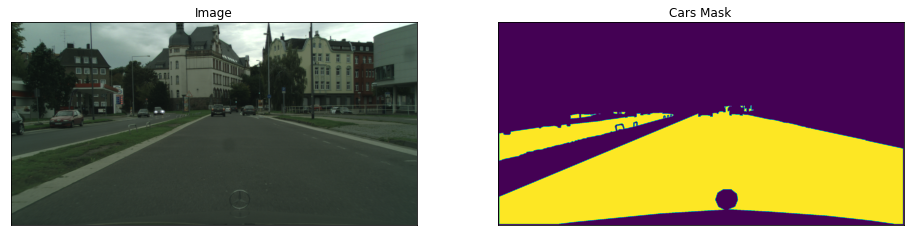

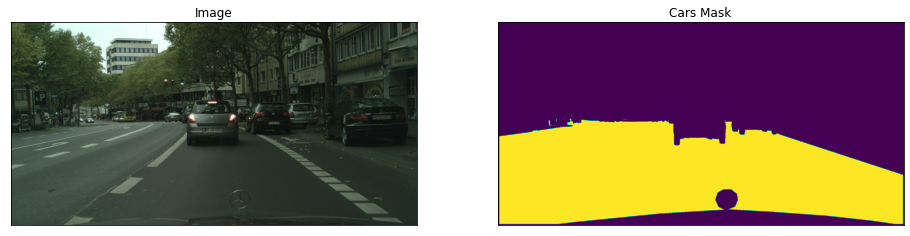

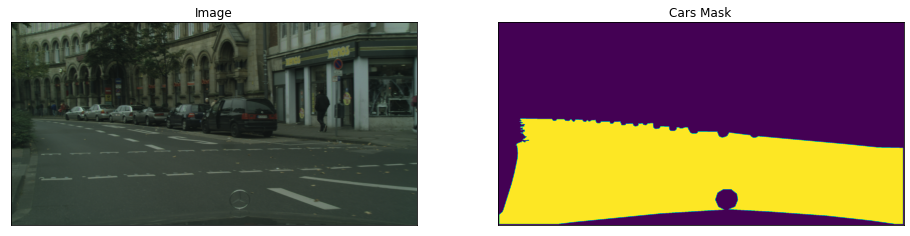

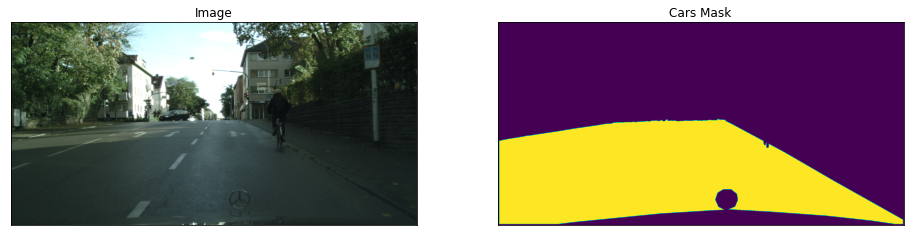

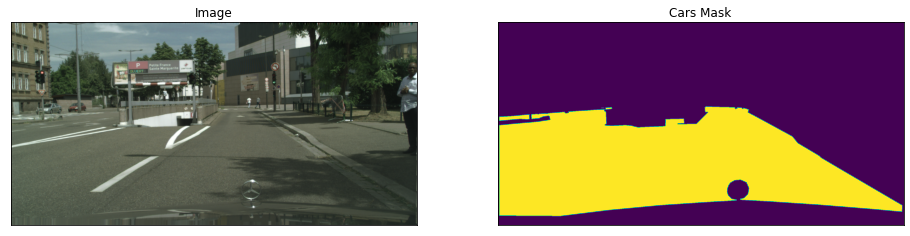

In [7]:
# Lets look at data we have. Lets search for an image with the class. (pick a low-used one e.g. parking)

# exempel = 174, 175
i = 5
for i in [1, 11, 100, 500, 1500]: 
    image, mask = dataset[i] # get some sample

    CU.visualize(
        image=image, 
        cars_mask=mask.squeeze(),
    )

In [13]:
height = 256
width = 512

In [14]:
def get_training_augmentation():
    train_transform = [
        Resize(height, width, always_apply=True), 
        
        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0.1, shift_limit=0.1, p=1, border_mode=0),

        # albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=128, width=256, p=0.5),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        Resize(height, width, always_apply=True), 
        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        Resize(height, width, always_apply=True),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

/home/jens/ml_venv/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/home/jens/ml_venv/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/home/jens/ml_venv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/jens/ml_venv/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/home/jens/ml_v

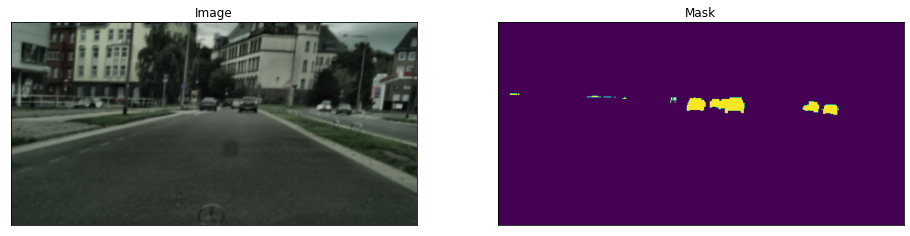

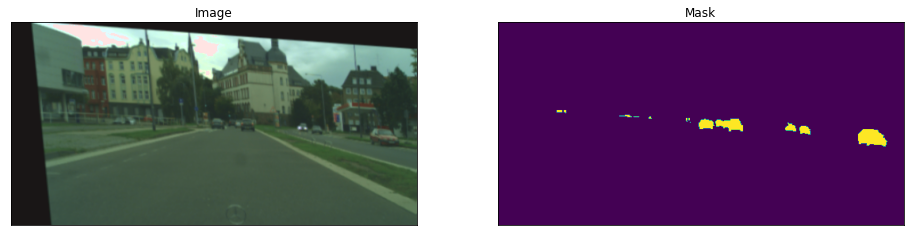

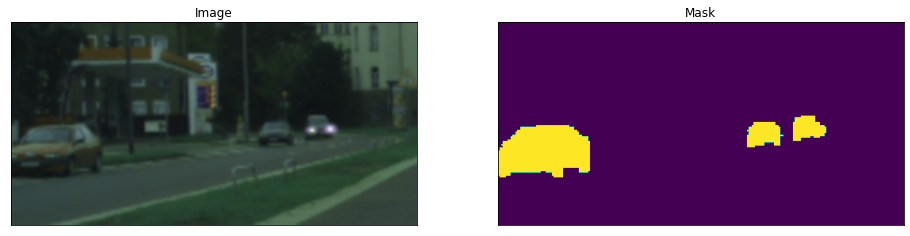

In [15]:
#### Visualize resulted augmented images and masks

augmented_dataset = CD.CityScapes(
    training_images, 
    training_labels, 
    augmentation=get_training_augmentation(), 
    classes=['car'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    CU.visualize(image=image, mask=mask.squeeze(-1))

## Creating and training model 

In [17]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [18]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'

CLASSES = ['road', 'sidewalk', 'building', 'wall', 
           'fence', 'pole', 'traffic light', 'traffic sign', 
           'vegetation', 'terrain', 'sky', 
           'person', 'rider', 
           'car', 'truck', 'bus', 'train', 'motorcycle', 'bicycle']


ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [20]:
train_dataset = CD.CityScapes_class_merge(
    training_images, 
    training_labels, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
    preload=True,
)

valid_dataset = CD.CityScapes_class_merge(
    validation_images, 
    validation_labels, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
    preload=True,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

/home/jens/ml_venv/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/home/jens/ml_venv/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/home/jens/ml_venv/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/home/jens/ml_venv/lib/python3.8/site-packages/albumentations/imgaug/transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/home/jens/ml_v

  0%|          | 0/2215 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [21]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [22]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [23]:
max_score = 0
train_history = []
val_history = []

for i in range(0, 3):    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    train_history.append(train_logs)
    val_history.append(valid_logs)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 1:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|                                                                                                                                                                                                         | 0/277 [00:00<?, ?it/s]

/home/jens/ml_venv/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:16<00:00, 30.00it/s, dice_loss - 0.198, iou_score - 0.6925]
Model saved!

Epoch: 1
valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:16<00:00, 30.00it/s, dice_loss - 0.1731, iou_score - 0.721]
Model saved!
Decrease decoder learning rate to 1e-5!

Epoch: 2
valid: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:16<00:00, 30.23it/s, dice_loss - 0.1685, iou_score - 0.7281]
Model saved!


## Testing the model

In [24]:

# load best saved checkpoint
best_model = torch.load('./best_model.pth')

In [28]:
# create test dataset
test_dataset = CD.CityScapes_class_merge(
    test_images, 
    test_labels, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
    preload=True,
)

test_dataloader = DataLoader(test_dataset)

  0%|          | 0/760 [00:00<?, ?it/s]

In [29]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 760/760 [00:37<00:00, 20.16it/s, dice_loss - 0.164, iou_score - 0.7329]


In [30]:
# test dataset without transformations for image visualization
test_dataset_vis = CD.CityScapes_class_merge(
    validation_images, 
    validation_labels, 
    classes=CD.CityScapes.CLASSES,
    augmentation=get_validation_augmentation(), 
)

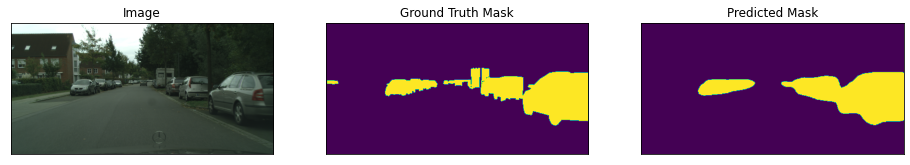

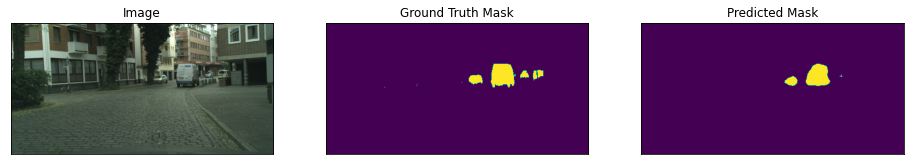

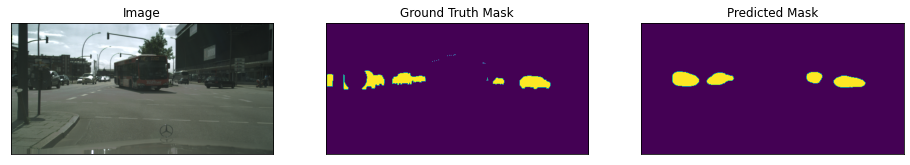

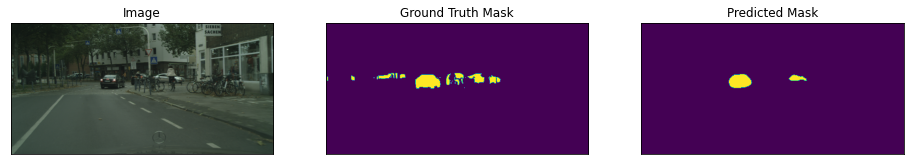

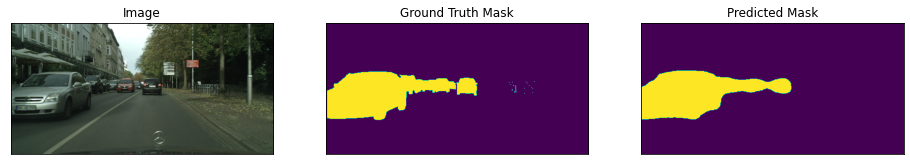

In [34]:
for i in range(5):
    n = np.random.choice(len(validation_images))
    
    image_vis = test_dataset.visualize(n)
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    CU.visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask[13,:,:], 
        predicted_mask=pr_mask[13,:,:]
    )